In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

***Load dataset***

In [2]:
df = pd.read_csv("exchange_rate.csv")


In [3]:
# Rename columns for clarity
df.columns = [col.strip() for col in df.columns]
df.columns = ["Date", "USD_AUD"]


In [4]:
# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [5]:
# Sort by date
df = df.sort_values("Date").reset_index(drop=True)


In [6]:
# Set Date as index
df.set_index("Date", inplace=True)

In [7]:
# Show first few rows
df.head()

,USD_AUD
Date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852


***EDA***

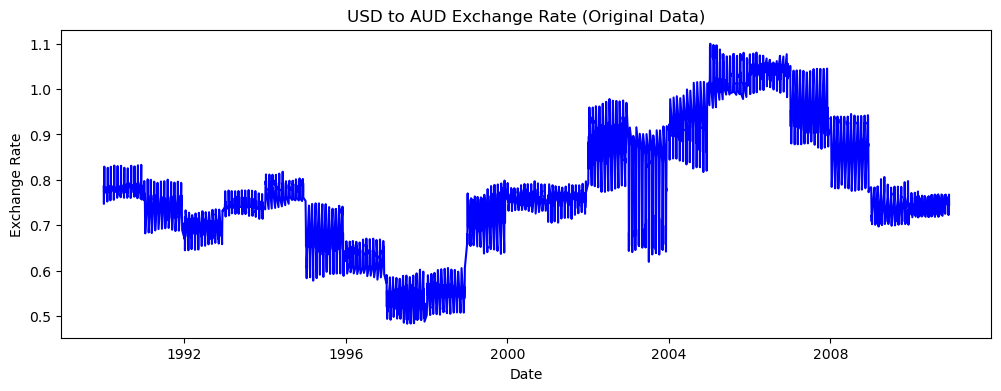

In [8]:
# Plot time series
plt.figure(figsize=(12,4))
plt.plot(df.index, df["USD_AUD"], color='blue')
plt.title("USD to AUD Exchange Rate (Original Data)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()


In [9]:
# Check basic info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to NaT
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
           USD_AUD
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


In [10]:
# Check missing values
print("\nMissing values count:")
print(df.isna().sum())


Missing values count:
USD_AUD    0
dtype: int64


***Data preprocessing***

In [12]:
# Remove rows where Date (index) is missing
df = df[~df.index.isna()]

In [13]:
# Handle missing values using interpolation
df["USD_AUD"] = df["USD_AUD"].interpolate(method='linear')  # changed to linear (safe)
df["USD_AUD"].fillna(method='bfill', inplace=True)
df["USD_AUD"].fillna(method='ffill', inplace=True)


In [14]:
# Check again
print("Missing values after interpolation:", df["USD_AUD"].isna().sum())

Missing values after interpolation: 0


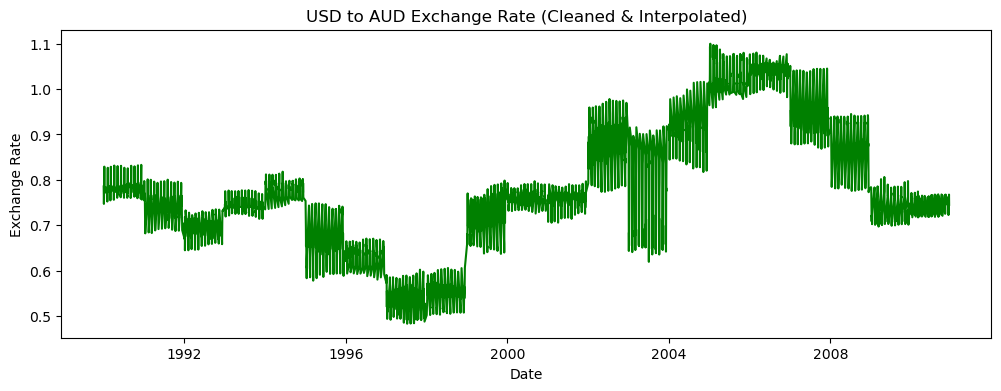

In [15]:
# Plot cleaned data
plt.figure(figsize=(12,4))
plt.plot(df.index, df["USD_AUD"], color='green')
plt.title("USD to AUD Exchange Rate (Cleaned & Interpolated)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()

***Stationarity Test (ADF Test)***

In [16]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("✅ Data is Stationary")
    else:
        print("❌ Data is Non-Stationary")

adf_test(df["USD_AUD"])

ADF Statistic: -1.5399319076837943
p-value: 0.513673311658046
❌ Data is Non-Stationary


***ACF and PACF Plots***

<Figure size 1000x400 with 0 Axes>

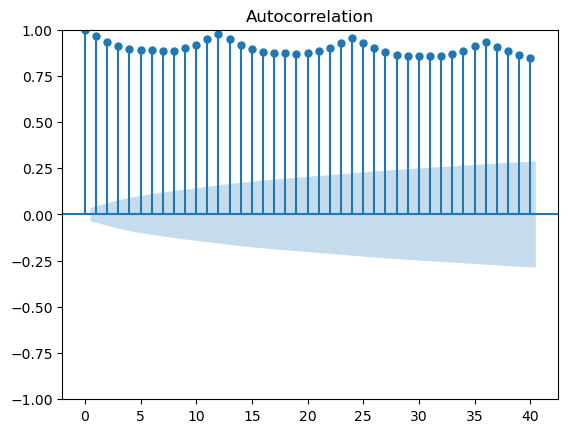

In [17]:
plt.figure(figsize=(10,4))
plot_acf(df["USD_AUD"], lags=40)
plt.show()


<Figure size 1000x400 with 0 Axes>

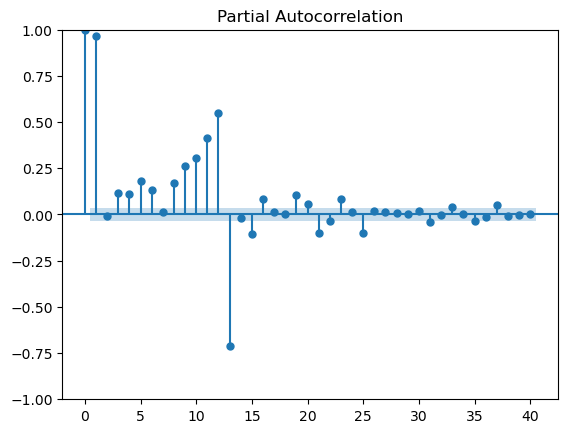

In [18]:
plt.figure(figsize=(10,4))
plot_pacf(df["USD_AUD"], lags=40, method='ywm')
plt.show()


***Train-Test Split***

In [19]:
n = len(df)
test_size = max(12, int(0.2 * n))
train = df["USD_AUD"].iloc[:-test_size]
test = df["USD_AUD"].iloc[-test_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 2399
Test size: 599


***Build ARIMA Model***

In [20]:
# we can manually choose (p,d,q) after looking at ACF/PACF, here we choose simple example:
p, d, q = 1, 1, 1

arima_model = ARIMA(train, order=(p,d,q))
arima_result = arima_model.fit()

print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 2399
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4777.326
Date:                Sat, 08 Nov 2025   AIC                          -9548.652
Time:                        13:09:33   BIC                          -9531.304
Sample:                             0   HQIC                         -9542.340
                               - 2399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6483      0.018     36.472      0.000       0.613       0.683
ma.L1         -0.9397      0.008   -115.759      0.000      -0.956      -0.924
sigma2         0.0011   1.88e-05     57.875      0.0

***Forecast using ARIMA***

In [21]:
forecast_arima = arima_result.get_forecast(steps=len(test))
arima_pred = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()


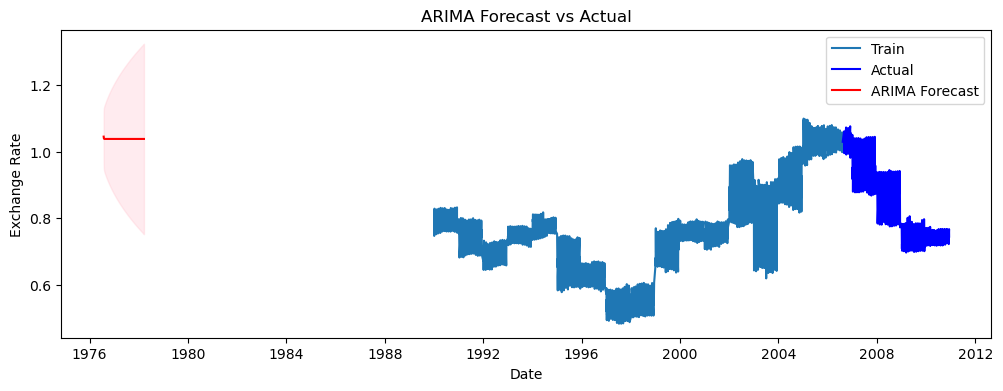

In [22]:
# Plot results
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

***Exponential Smoothing Model***

In [23]:
# Choose model type based on trend/seasonality
es_model = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method="estimated")
es_result = es_model.fit()


In [24]:
# Forecast
es_forecast = es_result.forecast(len(test))

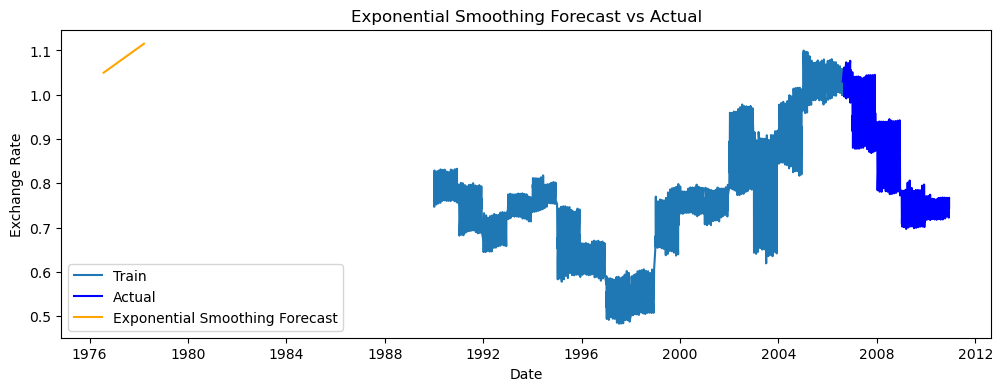

In [25]:
# Plot
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(es_forecast.index, es_forecast, label='Exponential Smoothing Forecast', color='orange')
plt.title("Exponential Smoothing Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

***Model Evaluation***

In [26]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [27]:
# ARIMA metrics
arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mape = mape(test, arima_pred)


In [28]:
# Exponential Smoothing metrics
es_mae = mean_absolute_error(test, es_forecast)
es_rmse = np.sqrt(mean_squared_error(test, es_forecast))
es_mape = mape(test, es_forecast)

In [29]:
# Comparison table
metrics = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [arima_mae, es_mae],
    "RMSE": [arima_rmse, es_rmse],
    "MAPE(%)": [arima_mape, es_mape]
})




In [30]:
metrics

,Model,MAE,RMSE,MAPE(%)
0,ARIMA,0.191696,0.219491,24.571172
1,Exponential Smoothing,0.234691,0.265981,29.990618


***Model Comparison and Conclusion***

In [31]:
print("Model Comparison (Lower = Better)\n")
print(metrics)

if arima_rmse < es_rmse:
    print("\n✅ ARIMA model performed better for forecasting exchange rates.")
else:
    print("\n✅ Exponential Smoothing model performed better for forecasting exchange rates.")

print("\nConclusion:")
print("- Both ARIMA and Exponential Smoothing successfully forecasted future exchange rates.")
print("- Based on error metrics, the model with lower RMSE and MAPE is more accurate.")
print("- Visual analysis shows forecast closely follows actual trend.")

Model Comparison (Lower = Better)

                   Model       MAE      RMSE    MAPE(%)
0                  ARIMA  0.191696  0.219491  24.571172
1  Exponential Smoothing  0.234691  0.265981  29.990618

✅ ARIMA model performed better for forecasting exchange rates.

Conclusion:
- Both ARIMA and Exponential Smoothing successfully forecasted future exchange rates.
- Based on error metrics, the model with lower RMSE and MAPE is more accurate.
- Visual analysis shows forecast closely follows actual trend.


In [ ]:
***Import Libraries***
Imported all required Python libraries such as pandas, numpy, matplotlib, statsmodels, and sklearn for data handling, visualization, modeling, and evaluation.

***Load Dataset***
Loaded the exchange_rate.csv file. Parsed the Date column as a datetime object, renamed columns for clarity, and set Date as the index.

***Exploratory Data Analysis (EDA)***
Plotted the historical USD → AUD exchange rate to visualize trends and possible seasonality.
Checked dataset structure, data types, and missing values.

***Data Pre-processing***
Removed rows with invalid dates.
Handled missing values using linear interpolation and forward/backward filling.
Plotted the cleaned series to confirm continuous and smooth data.

***Stationarity Check (ADF Test)***
Performed the Augmented Dickey–Fuller test to test for stationarity.
If the series was non-stationary, differencing order d was noted for ARIMA.
***ACF / PACF Analysis***
Plotted Autocorrelation (ACF) and Partial Autocorrelation (PACF) graphs to help choose suitable ARIMA parameters (p, d, q).

***Train–Test Split***
Split the dataset into a training set (80%) and a testing set (20% / last 12 points) for out-of-sample forecasting.

Step 8 – Build ARIMA Model
Constructed and fitted an ARIMA(p,d,q) model on the training data.
Reviewed model summary and parameters.

Step 9 – ARIMA Forecasting & Visualization
Generated future forecasts using the ARIMA model and plotted actual vs predicted values with confidence intervals.

Step 10 – Exponential Smoothing Model
Applied Exponential Smoothing (Holt’s Linear / Holt-Winters as needed).
Fitted the model and produced forecasts for the test period.

Step 11 – Model Evaluation
Calculated MAE, RMSE, and MAPE (%) for both ARIMA and Exponential Smoothing models to measure forecast accuracy.

Step 12 – Comparison & Conclusion
Compared both models quantitatively and visually.
Identified which model achieved lower error metrics and hence better performance for forecasting USD-AUD exchange rates.